In [1]:

# ----------------------------------
# 1. Install Dependencies
# ----------------------------------

# Install Kaggle API and hmmlearn
!pip install kaggle hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.0 MB/s eta 0:00:00


In [2]:

# ----------------------------------
# 2. Set Up Kaggle API and Download Dataset
# ----------------------------------

# Upload kaggle.json (run this cell, then upload the file when prompted)
from google.colab import files
files.upload()  # Upload kaggle.json

# Set up Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the ESA-ADB Challenge dataset
!kaggle competitions download -c esa-adb-challenge

# Unzip the dataset
!unzip esa-adb-challenge.zip -d esa_adb_challenge

# List the downloaded files
!ls esa_adb_challenge

Saving kaggle.json to kaggle.json
Archive:  esa-adb-challenge.zip
  inflating: esa_adb_challenge/sample_submission.parquet  
  inflating: esa_adb_challenge/target_channels.csv  
  inflating: esa_adb_challenge/test.parquet  
  inflating: esa_adb_challenge/train.parquet  
sample_submission.parquet  target_channels.csv	test.parquet  train.parquet


In [4]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.1 MB/s eta 0:00:00


In [5]:
# ----------------------------------
# 3. Import Libraries
# ----------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
import scipy.sparse as sp
import os
import time

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

Target Channels Loaded: ['channel_12', 'channel_13', 'channel_14', 'channel_15', 'channel_16'] ... (total: 58 )

Training Data Shape: (14728321, 89)
Test Data Shape: (521280, 88)
Target Channels: 58 channels
Sample Submission Shape: (521280, 2)

Training Data Head:
   id  channel_1  channel_10  channel_11  channel_12  channel_13  channel_14  \
0   0    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
1   1    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
2   2    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
3   3    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
4   4    0.13791         0.0         0.0    0.317175    0.371764    0.297205   

   channel_15  channel_16  channel_17  ...  telecommand_351  telecommand_352  \
0    0.130113    0.766769    0.349474  ...              0.0              0.0   
1    0.130113    0.766769    0.349474  ...              0.0              0.0   
2    0.130113

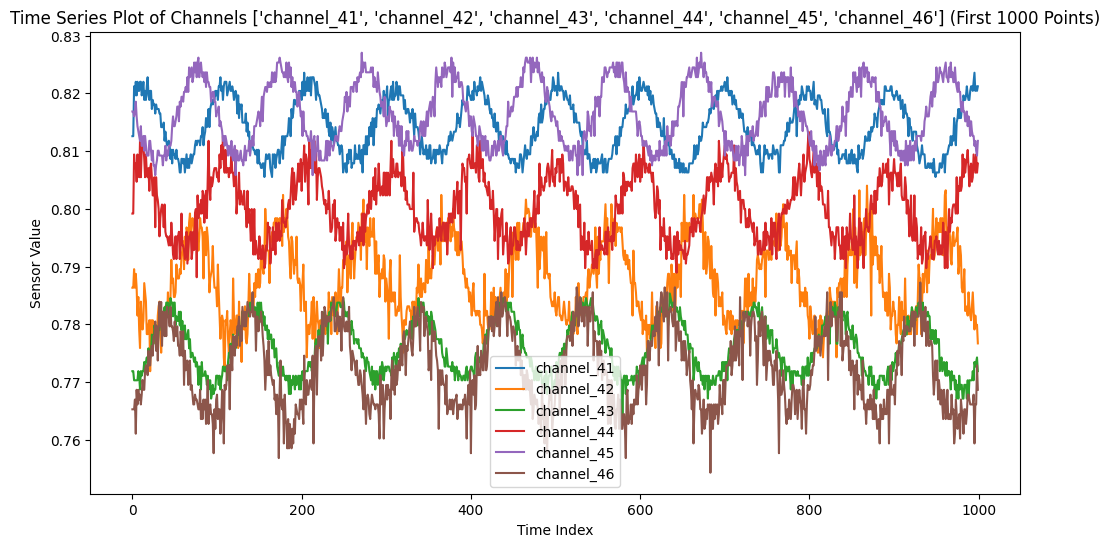

In [6]:
# ----------------------------------
# 4. Load and Explore the Data
# ----------------------------------

# Define file paths (Colab environment)
data_dir = "esa_adb_challenge"
train_file = os.path.join(data_dir, "train.parquet")
test_file = os.path.join(data_dir, "test.parquet")
target_channels_file = os.path.join(data_dir, "target_channels.csv")
submission_file = os.path.join(data_dir, "sample_submission.parquet")

# Load target channels
target_channels_df = pd.read_csv(target_channels_file)
target_channels = target_channels_df["target_channels"].tolist()  # Use correct column name
print("Target Channels Loaded:", target_channels[:5], "... (total:", len(target_channels), ")")

# Load other data
train_df = pd.read_parquet(train_file)
test_df = pd.read_parquet(test_file)
sample_submission = pd.read_parquet(submission_file)

# Display basic info
print("\nTraining Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("Target Channels:", len(target_channels), "channels")
print("Sample Submission Shape:", sample_submission.shape)

# Preview training data
print("\nTraining Data Head:")
print(train_df.head())

# Check anomaly distribution
print("\nAnomaly Distribution in Training Data:")
print(train_df["is_anomaly"].value_counts(normalize=True))

# Verify is_anomaly is binary
print("\nUnique values in is_anomaly:", np.unique(train_df["is_anomaly"]))

# Visualize a subset of channels (41–46 recommended, if available)
subset_channels = [ch for ch in target_channels if ch in [f"channel_{i}" for i in range(41, 47)]]
if not subset_channels:
    print("Warning: Channels 41–46 not found in target_channels. Using first 6 target channels instead.")
    subset_channels = target_channels[:6]
plt.figure(figsize=(12, 6))
for channel in subset_channels:
    plt.plot(train_df.index[:1000], train_df[channel][:1000], label=channel)
plt.title(f"Time Series Plot of Channels {subset_channels} (First 1000 Points)")
plt.xlabel("Time Index")
plt.ylabel("Sensor Value")
plt.legend()
plt.show()



In [7]:

# ----------------------------------
# 5. Preprocess the Data
# ----------------------------------
import torch
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph

# Select features (start with subset channels, then scale to all target channels)
features = subset_channels  # Replace with target_channels for full model
X_train = train_df[features].values
X_test = test_df[features].values
y_train = train_df["is_anomaly"].values

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Split training data into train/validation (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(X_train_scaled))
X_train_split = X_train_scaled[:train_size]
y_train_split = y_train[:train_size]
X_val_split = X_train_scaled[train_size:]
y_val_split = y_train[train_size:]

print("Training Split Shape:", X_train_split.shape)
print("Validation Split Shape:", X_val_split.shape)

def create_graph_data(X, y, k=5):
    # Node features: X (features for each time point)
    x = torch.tensor(X, dtype=torch.float)

    # Create edges using k-nearest neighbors based on Euclidean distance
    adj = kneighbors_graph(X, n_neighbors=k, mode='connectivity', include_self=False)
    edge_index = torch.tensor(np.array(adj.nonzero()), dtype=torch.long)

    # Labels
    y = torch.tensor(y, dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y)

# Create graph data objects
train_data = create_graph_data(X_train_split, y_train_split)
val_data = create_graph_data(X_val_split, y_val_split)
test_data = create_graph_data(X_test_scaled, np.zeros(len(X_test_scaled)))  # Test labels unknown

print("Train Graph Data:", train_data)
print("Validation Graph Data:", val_data)
print("Test Graph Data:", test_data)


Training Split Shape: (11782656, 6)
Validation Split Shape: (2945665, 6)
Train Graph Data: Data(x=[11782656, 6], edge_index=[2, 58913280], y=[11782656])
Validation Graph Data: Data(x=[2945665, 6], edge_index=[2, 14728325], y=[2945665])
Test Graph Data: Data(x=[521280, 6], edge_index=[2, 2606400], y=[521280])


In [8]:
# ----------------------------------
# 6. Train Graph Neural Network (GNN) Autoencoder
# ----------------------------------

# Define GNN Autoencoder model
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels // 2)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class GCNAutoencoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNAutoencoder, self).__init__()
        self.encoder = GCNEncoder(in_channels, hidden_channels)
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels // 2, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, out_channels)
        )

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        x_recon = self.decoder(z)
        return x_recon, z

# Initialize model, optimizer, and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNAutoencoder(in_channels=X_train_split.shape[1], hidden_channels=16, out_channels=X_train_split.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train on normal data only
normal_indices = np.where(y_train_split == 0)[0]
X_train_normal = X_train_split[normal_indices]
train_normal_data = create_graph_data(X_train_normal, np.zeros(len(X_train_normal)))
train_normal_data = train_normal_data.to(device)

# Training loop
print("\nStarting GNN Autoencoder training...")
start_time = time.time()
model.train()
for epoch in range(50):  # Adjust epochs as needed
    optimizer.zero_grad()
    recon, _ = model(train_normal_data.x, train_normal_data.edge_index)
    loss = F.mse_loss(recon, train_normal_data.x)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
end_time = time.time()
print(f"GNN Autoencoder training completed in {end_time - start_time:.2f} seconds!")

# Compute anomaly scores for validation set
model.eval()
val_data = val_data.to(device)
with torch.no_grad():
    recon, _ = model(val_data.x, val_data.edge_index)
    val_scores = torch.mean((recon - val_data.x) ** 2, dim=1).cpu().numpy()
print(f"Anomaly Scores Shape (Validation): {val_scores.shape}")
print(f"Sample Anomaly Scores (Validation, first 5): {val_scores[:5]}")

# Determine anomaly threshold (95th percentile of normal data scores)
normal_data = create_graph_data(X_train_normal, np.zeros(len(X_train_normal))).to(device)
with torch.no_grad():
    recon, _ = model(normal_data.x, normal_data.edge_index)
    normal_scores = torch.mean((recon - normal_data.x) ** 2, dim=1).cpu().numpy()
threshold = np.percentile(normal_scores, 95)  # Adjust for precision
print(f"Anomaly Threshold (95th percentile): {threshold}")

# Predict anomalies on validation set
print("\nPredicting anomalies on validation set...")
val_predictions = (val_scores > threshold).astype(int)
print(f"Predictions Shape (Validation): {val_predictions.shape}")
print(f"Unique values in val_predictions: {np.unique(val_predictions)}")
print(f"Number of predicted anomalies: {np.sum(val_predictions)}")


Starting GNN Autoencoder training...
Epoch 0, Loss: 0.0814
Epoch 10, Loss: 0.0294
Epoch 20, Loss: 0.0160
Epoch 30, Loss: 0.0096
Epoch 40, Loss: 0.0066
GNN Autoencoder training completed in 680.45 seconds!
Anomaly Scores Shape (Validation): (2945665,)
Sample Anomaly Scores (Validation, first 5): [0.00572819 0.00896671 0.00387067 0.00909174 0.0043555 ]
Anomaly Threshold (95th percentile): 0.011551127769052982

Predicting anomalies on validation set...
Predictions Shape (Validation): (2945665,)
Unique values in val_predictions: [0 1]
Number of predicted anomalies: 117071


y_val_split Shape: (2945665,)
Unique values in y_val_split: [0 1]

Validation Performance:
Precision: 0.3129
Recall: 0.1181
F1-Score: 0.1715


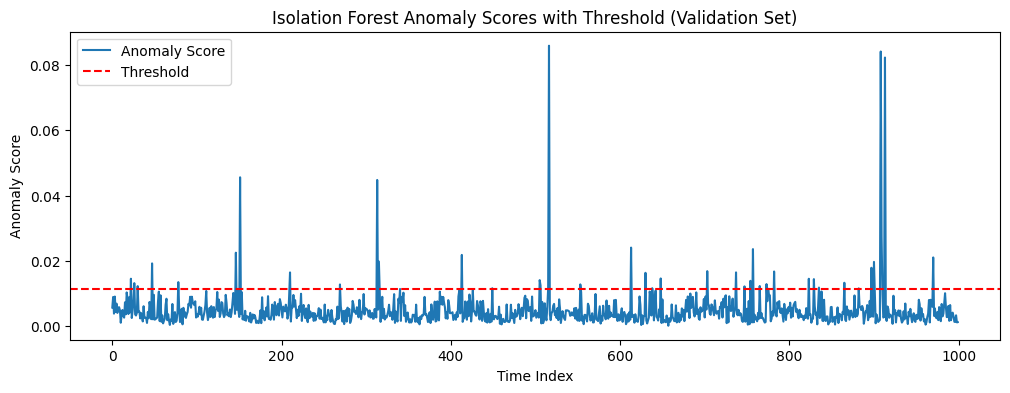

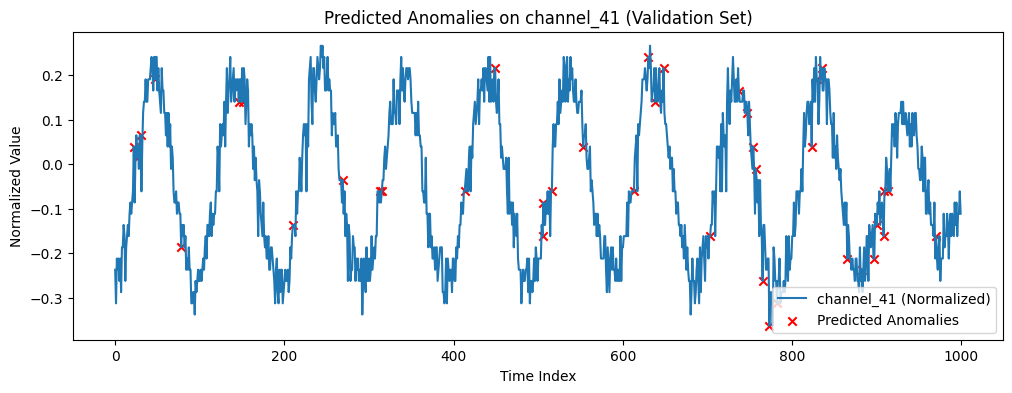

In [11]:
# ----------------------------------
# 7. Evaluate the Model
# ----------------------------------

# Ensure y_val_split and val_predictions are binary
print("y_val_split Shape:", y_val_split.shape)  # Should be (2945665,)
print("Unique values in y_val_split:", np.unique(y_val_split))  # Should be [0 1]

# Compute evaluation metrics
# Precision: TP / (TP + FP) - Minimize false positives
# Recall: TP / (TP + FN) - Maximize anomaly detection
# F1-Score: Balances precision and recall
precision = precision_score(y_val_split, val_predictions)
recall = recall_score(y_val_split, val_predictions)
f1 = f1_score(y_val_split, val_predictions)

print("\nValidation Performance:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Visualize anomaly scores on validation set (first 1000 points for clarity)
# Plots scores vs. time, with threshold line to show anomaly detection
plt.figure(figsize=(12, 4))
plt.plot(val_scores[:1000], label="Anomaly Score")
plt.axhline(threshold, color="r", linestyle="--", label="Threshold")
plt.title("Isolation Forest Anomaly Scores with Threshold (Validation Set)")
plt.xlabel("Time Index")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

# Plot predicted anomalies on a single channel (e.g., channel_12)
# Shows time series with anomalies marked as red X’s
plt.figure(figsize=(12, 4))
plt.plot(X_val_split[:1000, 0], label=f"{subset_channels[0]} (Normalized)")
plt.scatter(np.where(val_predictions[:1000] == 1)[0], X_val_split[:1000, 0][val_predictions[:1000] == 1],
            color="red", label="Predicted Anomalies", marker="x")
plt.title(f"Predicted Anomalies on {subset_channels[0]} (Validation Set)")
plt.xlabel("Time Index")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

In [10]:
# ----------------------------------
# 8. Generate Test Set Predictions
# ----------------------------------

print("\nComputing anomaly scores for test set...")
test_data = test_data.to(device)
with torch.no_grad():
    recon, _ = model(test_data.x, test_data.edge_index)
    test_scores = torch.mean((recon - test_data.x) ** 2, dim=1).cpu().numpy()
print(f"Test Scores Shape: {test_scores.shape}")
print(f"Sample Test Scores (first 5): {test_scores[:5]}")

test_predictions = (test_scores > threshold).astype(int)
print(f"Test Predictions Shape: {test_predictions.shape}")
print(f"Unique values in test_predictions: {np.unique(test_predictions)}")
print(f"Number of predicted anomalies: {np.sum(test_predictions)}")

submission_df = sample_submission.copy()
submission_df["is_anomaly"] = test_predictions
submission_df.to_parquet("submission.parquet")

print("\nSubmission File Prepared:")
print(submission_df.head())
files.download("submission.parquet")


Computing anomaly scores for test set...
Test Scores Shape: (521280,)
Sample Test Scores (first 5): [0.00474985 0.00605818 0.00469659 0.00242447 0.00597124]
Test Predictions Shape: (521280,)
Unique values in test_predictions: [0 1]
Number of predicted anomalies: 13359

Submission File Prepared:
         id  is_anomaly
0  14728321           0
1  14728322           0
2  14728323           0
3  14728324           0
4  14728325           0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>